[View in Colaboratory](https://colab.research.google.com/github/Marshallmaxiao/Resources/blob/master/Actify_0327.ipynb)

## Initialization

In [17]:
'''
instruction on modules installing:
If python shows "no module name xyz", use code below to install modules on your terminal
!pip install module_name
Below are necessay modules
'''
!pip install --upgrade -q gspread
!pip install gspread-dataframe
!pip install pandas
#Keyboard shortcut: ctrl+enter -> run current cell;  shift+enter -> run current cell and move to the next

In [0]:
#import packages
import pandas as pd
# from rpy2.robjects import r
# import rpy2.robjects.pandas2ri as pandas2ri
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.colab import auth
auth.authenticate_user()  # verify your account to read files which you have access to. Make sure you have permission to read the file!
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
def import_data(filename):
  spreadsheet = gc.open(filename) # Open file using its name. Use this if the file is already anywhere in your drive
  sheet =  spreadsheet.get_worksheet(0)  # 0 means the first sheet in the file
  df = pd.DataFrame(sheet.get_all_records())
  return(df)

In [25]:
both_users = import_data("both_users.csv")  
both_users = both_users.iloc[:, 1:]
# if error "Spreadsheet NOT FOUND" shows up, you may need to open the csv file in Drive and wait for Google to make a readable copy (one with green icon)
print(both_users.head(2),both_users.tail(2),'\n', '---------------------------------')
updata = import_data("updata.csv")
updata = updata.iloc[:, 1:]
print(updata.head(2))

         Date                        ReportUniqueID  Steps Target_Steps  Week
0  2017-09-21  ac3341b1-9546-442b-9661-cf7cb8072740   7058                 38
1  2017-09-21  8202d5d3-e352-49aa-9879-63db2e9194ce   5772                 38               Date                        ReportUniqueID  Steps Target_Steps  \
111499  2018-01-26  18514af0-0958-4e39-87e8-0f23fc09ae23    853         6000   
111500  2018-01-26  6114b9eb-1139-4279-9541-edbc63dc1407     31         4750   

        Week  
111499     4  
111500     4   
 ---------------------------------
                  app_id app_store app_version      date       event  \
0  com.actify.actifymove    iTunes       2.0.0  20171210  app_update   
1  com.actify.actifymove    iTunes       2.0.0  20171210  app_update   

                    key previous_timestamp previous_version   timestamp  \
0  previous_app_version         1510993291            1.2.0  1512938153   
1  previous_app_version         1510429537            1.2.0  1512911706   

 

In [26]:
#initial processing
cleanup = updata.loc[:,['user_id','date','app_version','previous_version']]  #exclude uneeded columns
cleanup['date'] =  cleanup['date'].apply(lambda x : datetime.strptime(str(x),'%Y%m%d'))
print(cleanup.head(2), cleanup.tail(2))
#filter user data before/after upgrading with recorded upgrading dates
up_userlist = cleanup['user_id'].tolist()
realsteps = both_users.loc[(both_users['ReportUniqueID'].isin(up_userlist))].reset_index(drop=True)
print('Valid rows before filtering both_user with update info:', len(both_users),'After:',len(realsteps))

                                user_id       date app_version  \
0  e47e800a-63b9-4a19-ac7c-adc1eb54af49 2017-12-10       2.0.0   
1  26997168-52f4-42a9-aef3-ac15a6988aa8 2017-12-10       2.0.0   

  previous_version  
0            1.2.0  
1            1.2.0                                      user_id       date app_version  \
4541  7953047c-7444-40ce-b1cd-319584155d5e 2018-02-14       2.1.2   
4542  9260e9dc-60cb-4f88-87fd-25bdc2a0b800 2018-02-14       2.1.2   

     previous_version  
4541            1.2.0  
4542            1.1.2  
Valid rows before filtering both_user with update info: 111501 After: 109798


In [27]:
#combine individual upgrading dates to steps data
up_datelist = cleanup['date'].tolist()
user_date = {}
for i in range(len(up_datelist)):
    user_date[up_userlist[i]] = up_datelist[i]
realsteps['up_date'] = realsteps['ReportUniqueID'].apply(lambda x: user_date[x])
realsteps.head()

,Date,ReportUniqueID,Steps,Target_Steps,Week,up_date
0,2017-09-21,ac3341b1-9546-442b-9661-cf7cb8072740,7058,,38,2018-01-25
1,2017-09-21,8202d5d3-e352-49aa-9879-63db2e9194ce,5772,,38,2017-12-09
2,2017-09-21,1b8ded61-545d-4293-be5a-25eb237ee28b,6002,,38,2017-12-23
3,2017-09-21,210f867a-6c67-4576-b63c-a3ca646ac669,12113,,38,2017-12-12
4,2017-09-21,6ebfe8b7-88a9-43d6-ba56-121e5f6d3aea,10559,,38,2018-02-18


In [28]:
# create new column for relative days to individual upgrading date
realsteps['Date'] = realsteps['Date'].apply(lambda x : datetime.strptime(x,'%Y-%m-%d'))
realsteps['Relative_day'] = realsteps['Date']-realsteps['up_date']
realsteps['Relative_day'] = realsteps['Relative_day'].apply(lambda x: x.days)
print('After cleanning we have', realsteps['ReportUniqueID'].nunique(), 'users')
realsteps.head()

After cleanning we have 1407 users


,Date,ReportUniqueID,Steps,Target_Steps,Week,up_date,Relative_day
0,2017-09-21,ac3341b1-9546-442b-9661-cf7cb8072740,7058,,38,2018-01-25,-126
1,2017-09-21,8202d5d3-e352-49aa-9879-63db2e9194ce,5772,,38,2017-12-09,-79
2,2017-09-21,1b8ded61-545d-4293-be5a-25eb237ee28b,6002,,38,2017-12-23,-93
3,2017-09-21,210f867a-6c67-4576-b63c-a3ca646ac669,12113,,38,2017-12-12,-82
4,2017-09-21,6ebfe8b7-88a9-43d6-ba56-121e5f6d3aea,10559,,38,2018-02-18,-150


## Previous Analysis

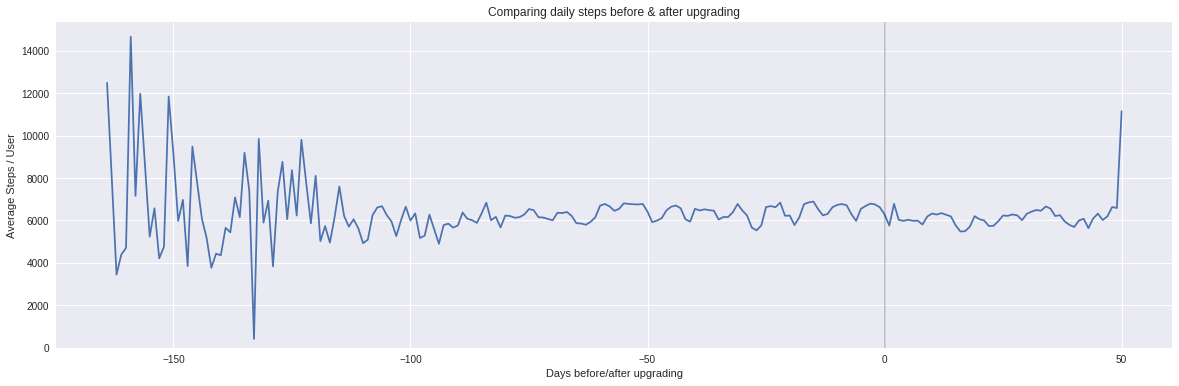

Note: The great fluctuation may be due to small numbers of upgraded users in the beginning
Average steps before upgrading: 6389.543579507651
Average steps after upgrading:  6102.5195091928645


In [30]:
# compare avg steps before & after individual upgrading for all users
bx = realsteps.groupby('Relative_day')['Steps'].mean().plot(figsize=(20,6))
bx.set(title='Comparing daily steps before & after upgrading' , xlabel='Days before/after upgrading',ylabel='Average Steps / User')
bx.set_ylim(ymin=0)
plt.axvline(x=0, color='black', alpha=0.2)

plt.show()

print('Note: The great fluctuation may be due to small numbers of upgraded users in the beginning')

print('Average steps before upgrading:', realsteps.loc[realsteps['Relative_day']<0]['Steps'].mean() )
print('Average steps after upgrading: ', realsteps.loc[realsteps['Relative_day']>=0]['Steps'].mean() )


Narrowed down 109798 rows by 2227 through excluding steps less than 100


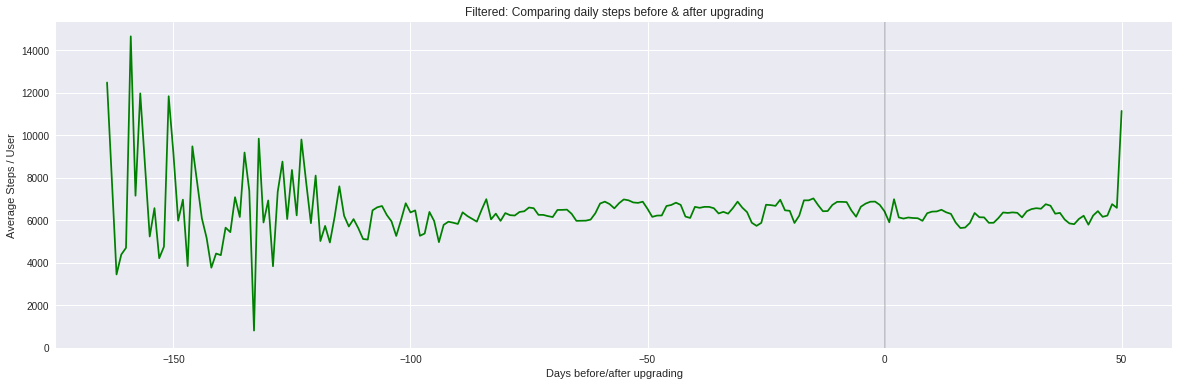

Average steps before upgrading: 6522.3631629365145
Average steps after upgrading:  6226.258373873515


In [9]:
# [exclude small step numbers] compare avg steps before & after individual upgrading for all users
thres = 100
realsteps_1 = realsteps.copy()
realsteps_1 = realsteps_1.loc[realsteps_1['Steps']>thres]
print('Narrowed down',len(realsteps),'rows by',len(realsteps)-len(realsteps_1), 'through excluding steps less than', thres)
bx = realsteps_1.groupby('Relative_day')['Steps'].mean().plot(figsize=(20,6), color='green')
bx.set(title='Filtered: Comparing daily steps before & after upgrading', xlabel='Days before/after upgrading',ylabel='Average Steps / User')
bx.set_ylim(ymin=0)
plt.axvline(x=0, color='black', alpha=0.2)

plt.show()

print('Average steps before upgrading:', realsteps_1.loc[realsteps_1['Relative_day']<0]['Steps'].mean() )
print('Average steps after upgrading: ', realsteps_1.loc[realsteps_1['Relative_day']>=0]['Steps'].mean() )

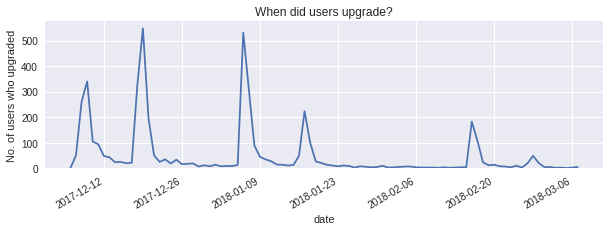

In [31]:
# When did users upgrade?
cx = cleanup.groupby('date')['user_id'].count().plot(figsize=(10,3))
cx.set(title='When did users upgrade?',ylabel='No. of users who upgraded')
cx.set_ylim(ymin=0)

plt.show()

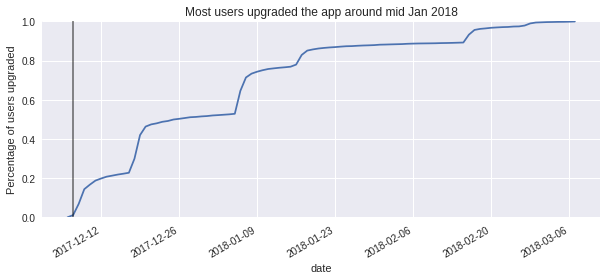

In [32]:

up_percent = cleanup.groupby('date')['user_id'].count()
up_percent = pd.DataFrame(up_percent).reset_index()
up_percent['cumsum'] = up_percent['user_id'].cumsum()
up_percent['cumpercent'] = up_percent['cumsum']/up_percent['cumsum'].max()
up_percent.set_index('date').head()

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(4)
up_percent.plot(x='date', y='cumpercent', ax=ax, legend=False)

ax.set(title='Most users upgraded the app around mid Jan 2018', ylabel='Percentage of users upgraded')
ax.set_ylim(ymin=0, ymax=1)
plt.axvline(x='2017-12-07', color='black', alpha=0.5)

plt.show()

In [12]:
'''Work after 03/17 meeting starts here'''

'Work after 03/17 meeting starts here'

In [13]:
weeks_compare = realsteps_1.copy()
weeks_compare = weeks_compare.query('Relative_day >= -21 & Relative_day <=21')
print("Number of rows of data from -21 to 21 days:", len(weeks_compare))

Number of rows of data from -21 to 21 days: 48945


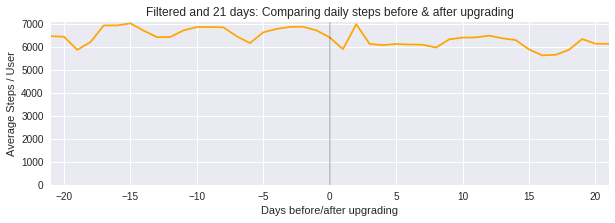

Average steps 3 weeks before upgrading: 6651.599328287132
Average steps 3 weeks after upgrading:  6194.475686301559


In [14]:
bx = weeks_compare.groupby('Relative_day')['Steps'].mean().plot(figsize=(10,3), color='orange')
bx.set(title='Filtered and 21 days: Comparing daily steps before & after upgrading', xlabel='Days before/after upgrading',ylabel='Average Steps / User')
bx.set_ylim(ymin=0)
bx.set_xlim(-21,21)
plt.axvline(x=0, color='black', alpha=0.2)

plt.show()

print('Average steps 3 weeks before upgrading:', weeks_compare.loc[weeks_compare['Relative_day']<0]['Steps'].mean() )
print('Average steps 3 weeks after upgrading: ', weeks_compare.loc[weeks_compare['Relative_day']>=0]['Steps'].mean() )

In [0]:
# new scratch

In [16]:
newlist = []
oldlist = realsteps_1['ReportUniqueID'].unique().tolist()
print(len(oldlist))
for user in oldlist:
    if(len(realsteps_1[(realsteps_1['ReportUniqueID']==user)&(realsteps_1['Relative_day']>=-21)&(realsteps_1['Relative_day']<=21)])>14):
        newlist.append(user)
    # at least 14 days of data
print(len(newlist))

1407
1319


In [0]:
avg_bf = []
avg_af = []
df = realsteps_1[(realsteps_1['Relative_day']>=-21)&(realsteps_1['Relative_day']<=21)]
for user in newlist:
    df_bf = df[(df['ReportUniqueID']==user) & (df['Relative_day']<0) & (df['Relative_day']>-21)]
    df_af = df[(df['ReportUniqueID']==user) & (df['Relative_day']>0) & (df['Relative_day']< 21)]
    avg_bf.append(df_bf['Steps'].mean())
    avg_af.append(df_af['Steps'].mean())

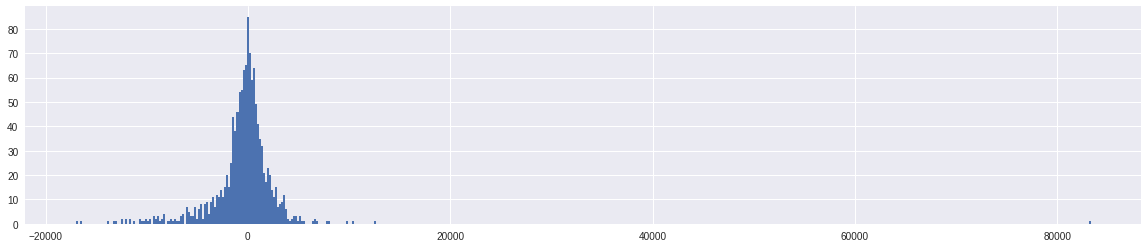

Ttest_indResult(statistic=2.908386519225277, pvalue=0.003664922533277574)
-455.80879912260565


In [18]:
test = pd.DataFrame({'avg_bf':avg_bf, 'avg_af':avg_af})
test = test.dropna()
test['diff']=test['avg_af']-test['avg_bf']
plt.figure(figsize=(20,4))
plt.hist(x=test['diff'] , bins=500 ) #more bins more details. Or just use 'auto'
plt.show()

newavg_bf = test['avg_bf'].tolist()
newavg_af = test['avg_af'].tolist()
import scipy.stats as s
print(s.ttest_ind(newavg_bf, newavg_af, equal_var=False))
print(test['diff'].mean())

a = test['diff']

In [0]:
#03/22 Robustness testing: weeks-4~-1, weeks 1~4 (leave weeks in the middle)

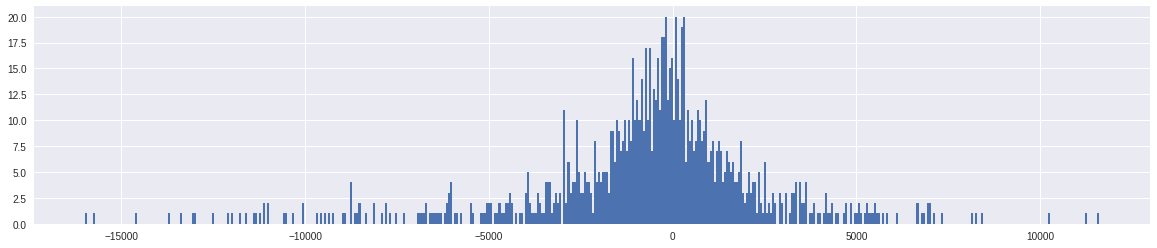

Ttest_indResult(statistic=4.319674829611118, pvalue=1.641405362246592e-05)
-687.1745314697969


In [20]:
avg_bf = []
avg_af = []
df = realsteps_1
for user in oldlist:
    df_bf = df[(df['ReportUniqueID']==user) & (df['Relative_day']<-7) & (df['Relative_day']>-28)]
    df_af = df[(df['ReportUniqueID']==user) & (df['Relative_day']> 7) & (df['Relative_day']< 28)]
    avg_bf.append(df_bf['Steps'].mean())
    avg_af.append(df_af['Steps'].mean())

test = pd.DataFrame({'avg_bf':avg_bf, 'avg_af':avg_af})
test = test.dropna()
test['diff']=test['avg_af']-test['avg_bf']
plt.figure(figsize=(20,4))
plt.hist(x=test['diff'], bins=500  )  #more bins more details. Or just use 'auto'
plt.show()

newavg_bf = test['avg_bf'].tolist()
newavg_af = test['avg_af'].tolist()

import scipy.stats as s
print(s.ttest_ind(newavg_bf, newavg_af, equal_var=False))
print(test['diff'].mean())

b = test['diff']

In [0]:
# Mann whitney test
a = a.tolist()
b = b.tolist()

In [27]:
from scipy.stats import mannwhitneyu
mannwhitneyu(a,b)

MannwhitneyuResult(statistic=624632.0, pvalue=0.020786047658918547)

In [0]:
# 04/01  weather and steps

In [60]:
realsteps.head()

,Date,ReportUniqueID,Steps,Target_Steps,Week,up_date,Relative_day
0,2017-09-21,ac3341b1-9546-442b-9661-cf7cb8072740,7058,,38,2018-01-25,-126
1,2017-09-21,8202d5d3-e352-49aa-9879-63db2e9194ce,5772,,38,2017-12-09,-79
2,2017-09-21,1b8ded61-545d-4293-be5a-25eb237ee28b,6002,,38,2017-12-23,-93
3,2017-09-21,210f867a-6c67-4576-b63c-a3ca646ac669,12113,,38,2017-12-12,-82
4,2017-09-21,6ebfe8b7-88a9-43d6-ba56-121e5f6d3aea,10559,,38,2018-02-18,-150


## ** Weather and Steps**

In [0]:
# Get weather data
# https://www.wunderground.com/history/station/06240/2017/9/21/CustomHistory.html?dayend=26&monthend=1&yearend=2018&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=
# Select mean temperature and event (snow, rain, etc.) and save to weather.xlsx in Google Drive

In [148]:
weather = import_data("WeatherAmsterdam.xlsx")  
print(weather.head())

   AvgTemp       Date             Event
0       58  9/21/2017                  
1       54  9/22/2017  Fog\r\n,\r\nRain
2       54  9/23/2017               Fog
3       55  9/24/2017               Fog
4       57  9/25/2017               Fog


In [112]:
avg_steps = pd.DataFrame(realsteps.groupby("Date")['Steps'].mean()).reset_index()
avg_steps.head()

,Date,Steps
0,2017-09-21,6450.300000
1,2017-09-22,6270.069284
2,2017-09-23,6250.390519
3,2017-09-24,5483.197044
4,2017-09-25,6176.724272


In [0]:
# Regression on  steps ~ temp + rain/snow

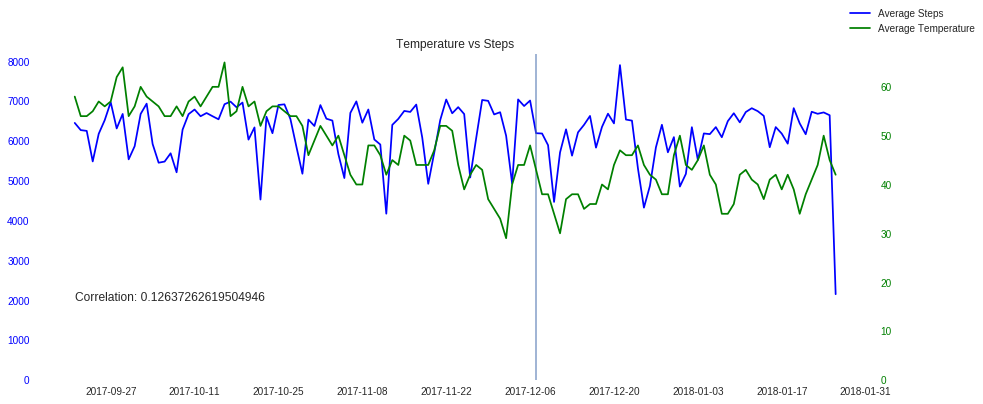

In [161]:
fig1  = plt.figure(figsize=(15,6))
ax = fig1.add_subplot(111)
ax.plot(avg_steps.Date, avg_steps.Steps, c='b', label='Average Steps')
ax.set_ylim(ymin=0)
ax.axvline(x='2017-12-07', alpha=0.6)
ax.tick_params('y', colors='b')

bx = ax.twinx()
bx.plot(avg_steps.Date, weather['AvgTemp'], c='g', label='Average Temperature')
bx.set_ylim(ymin=0)
bx.tick_params('y', colors='g')

ax.set_facecolor('white')
ax.set(title='Temperature vs Steps')
s = "Correlation: " + str(np.corrcoef(avg_steps['Steps'], weather['AvgTemp'])[0][1])
ax.text('2017-09-21',2000,s)

fig1.legend()
plt.show()

## Regression on  steps ~ temp + rain/snow

In [195]:
weather['rain/snow'] =  weather['Event'].apply(lambda x: 1 if ('Rain' in x) | ('Snow' in x)  else 0)
weather.head()

,AvgTemp,Date,Event,rain/snow
0,58,9/21/2017,,0
1,54,9/22/2017,"Fog\r\n,\r\nRain",1
2,54,9/23/2017,Fog,0
3,55,9/24/2017,Fog,0
4,57,9/25/2017,Fog,0


In [224]:
s = avg_steps['Steps'].tolist()
s = pd.Series(s, name='Steps')
weather['Steps']=s
weather.head()

,AvgTemp,Date,Event,rain/snow,Steps
0,58,9/21/2017,,0,6450.300000
1,54,9/22/2017,"Fog\r\n,\r\nRain",1,6270.069284
2,54,9/23/2017,Fog,0,6250.390519
3,55,9/24/2017,Fog,0,5483.197044
4,57,9/25/2017,Fog,0,6176.724272


In [252]:
import statsmodels.api as sm

X = weather.iloc[:,[0,3]].values
y = weather.iloc[:, -1].values

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1676.
Date:                Sun, 01 Apr 2018   Prob (F-statistic):           1.63e-91
Time:                        22:57:59   Log-Likelihood:                -1088.3
No. Observations:                 128   AIC:                             2181.
Df Residuals:                     126   BIC:                             2186.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           123.7321      4.296     28.799      0.0

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [251]:
# Linear Regression

# Importing the dataset
X = weather.iloc[:,[0,3]].values
y = weather.iloc[:, -1].values

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y.reshape(-1,1) ) # y only has one column, so we need to use .reshape(-1,1)

# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Fitting regression model to the dataset
from sklearn.linear_model import LinearRegression  
regressor = LinearRegression()  
regressor.fit(X_train, y_train)  

print(regressor.intercept_)  
print(regressor.coef_)  


[0.09887073]
[[ 0.06866255 -0.25404035]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [233]:
'''Polynomial regression (y = b0 + b1x1 + b2x^2 + ...)'''


#print(dataset.columns.tolist())
X = weather.iloc[:,[0,3]].values
y = weather.iloc[:, -1].values

#fitting polynomial regression to data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=4)
x_poly = poly_reg.fit_transform(X) # give powers (^2, ^3, ...) to x
#poly_reg.fit(x_poly, y)
lin_reg_2 = LinearRegression()  # connect variables with  + 
lin_reg_2.fit(x_poly,y)

plt.scatter(x,y,color='red')
plt.plot(x,lin_reg_2.predict(x_poly), color='blue' )
plt.title('Polynomial Regression')
plt.xlabel('Position Level')
plt.ylabel('salary')
plt.show()


NameError: ignored